# Exercício: predição de prazo de entrega

**Objetivo:** predizer prazo de entrega usando a base de dados do arquivo `processed_olist_orders.csv`

In [1]:
# ! pip install geopy matplotlib pandas scikit-learn seaborn

In [2]:
from geopy.distance import distance
import numpy as np
import pandas as pd

## bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Leitura dos dados

In [5]:
orders_df = pd.read_csv("processed_olist_orders.csv")

In [6]:
orders_df.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,freight_value,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,customer_lat,customer_long,seller_lat,seller_long
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.72,3149,sao paulo,SP,9350,maua,SP,-23.583452,-46.586284,-23.675542,-46.442547
1,8736140c61ea584cb4250074756d8f3b,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,7.79,8577,itaquaquecetuba,SP,9350,maua,SP,-23.494316,-46.364539,-23.675542,-46.442547
2,a0151737f2f0c6c0a5fd69d45f66ceea,delivered,2017-07-12 14:11:58,2017-07-12 14:30:18,2017-07-13 12:47:05,2017-07-18 16:24:42,2017-07-25 00:00:00,7.78,13820,jaguariuna,SP,9350,maua,SP,-22.694569,-46.985195,-23.675542,-46.442547
3,a3bf941183211246f0d42ad757cba127,delivered,2017-07-24 22:16:25,2017-07-25 22:25:11,2017-07-26 14:57:42,2017-07-28 19:06:46,2017-08-04 00:00:00,7.78,6298,osasco,SP,9350,maua,SP,-23.522863,-46.755315,-23.675542,-46.442547
4,1462290799412b71be32dd880eaf4e1b,delivered,2017-08-19 14:06:58,2017-08-22 04:10:55,2017-08-23 13:54:29,2017-08-29 19:35:06,2017-09-15 00:00:00,14.10,94130,gravatai,RS,9350,maua,SP,-29.922398,-51.038493,-23.675542,-46.442547


## Inspeção de algumas colunas

#### `order_status`: status do pedido

In [7]:
orders_df["order_status"].value_counts().reset_index().rename(columns={"index": "order_status", "order_status": "count"})

,order_status,count
0,delivered,86843
1,shipped,1044
2,canceled,420
3,invoiced,282
4,processing,268
5,unavailable,5
6,approved,1


### Dados por estado do `customer` e `seller`

In [8]:
states_count = orders_df["customer_state"].value_counts().reset_index().rename(columns={"index": "state", "customer_state": "customer"}) \
    .merge(orders_df["seller_state"].value_counts().reset_index().rename(columns={"index": "state", "seller_state": "seller"}),
           on="state", how="left").fillna(0)
states_count_melted = pd.melt(states_count, id_vars="state", var_name="user_type", value_name="count")

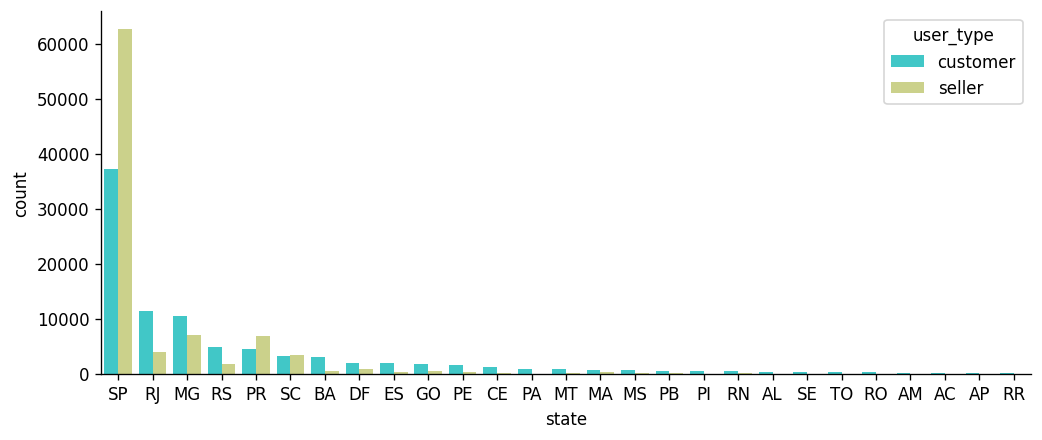

In [9]:
fig = plt.figure(figsize=(10, 4), dpi=120)
ax = fig.add_subplot(111)
sns.barplot(x="state", y="count", hue="user_type", data=states_count_melted, palette="rainbow", ax=ax)
sns.despine()

### Distribuição de `freight_value`: valor do frete

In [10]:
orders_df[["freight_value"]].describe()

,freight_value
count,88863.000000
mean,20.368021
std,16.020564
min,0.000000
25%,13.430000
50%,16.460000
75%,21.350000
max,409.680000


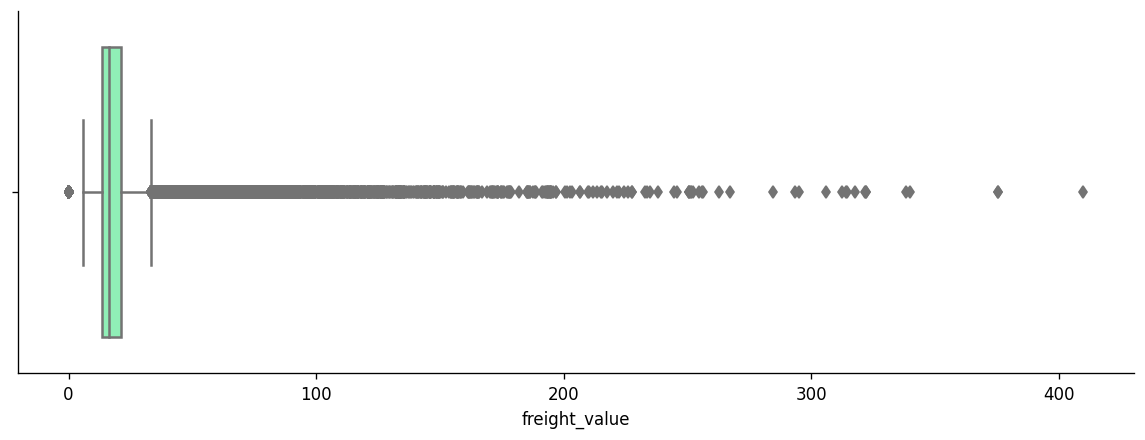

In [11]:
fig = plt.figure(figsize=(12, 4), dpi=120)
ax = fig.add_subplot(111)
sns.boxplot(x="freight_value", data=orders_df, palette="rainbow", ax=ax)
sns.despine()

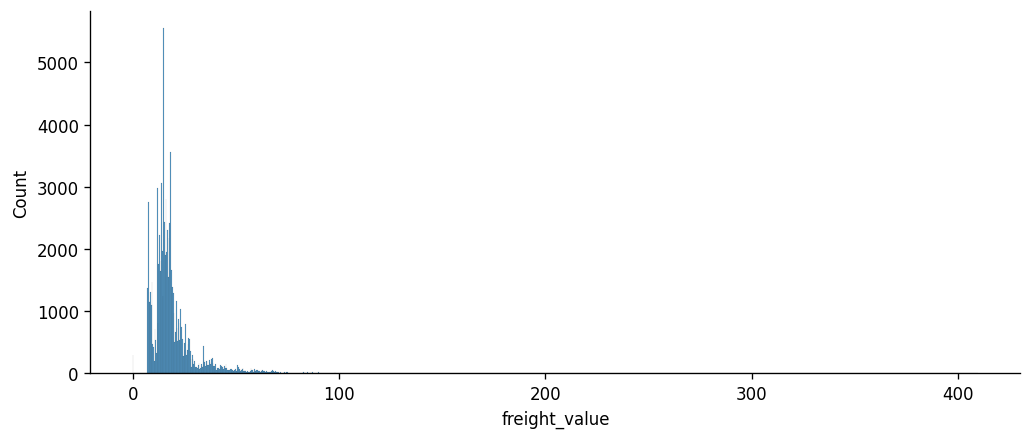

In [12]:
fig = plt.figure(figsize=(10, 4), dpi=120)
ax = fig.add_subplot(111)
sns.histplot(x="freight_value", data=orders_df, palette="rainbow", ax=ax)
sns.despine()

### Apenas dados com status `delivered` devem ser mantidos no dataset

In [13]:
orders_df = orders_df[orders_df["order_status"] == "delivered"].reset_index(drop=True)

## Criação de features

* `same_city`: se `customer_city` é igual a `seller_city`
* `same_state`: se `customer_state` é igual a `seller_state`
* `zip_code_prefix_match`: número de prefixos iguais entre `customer_zip_code_prefix` e `seller_zip_code_prefix` (ex. `012345` e `01355` têm `zip_code_prefix_match` = 2)
* `geo_distance`: distância calculada a partir da latitude e longitude entre `customer` e `seller`
* `from_to`: combinação de `seller_state` e `customer_state` (ex. se `seller_state` é `SP` e `customer_state` é `RJ`, então, `from_to` = `SP->RJ`)

<!-- **Extra**: para criar colunas com os dígitos do CEP:
```python
zip_code_prefix_cols = []
for colname in ["customer_zip_code_prefix", "seller_zip_code_prefix"]:
    new_cols = [f"{colname}_{num}" for num in range(1, 6)]
    zip_code_digits = pd.DataFrame(orders_df[colname].astype(str).str.zfill(5).apply(list).tolist(), columns=new_cols)
    orders_df = orders_df.merge(zip_code_digits, left_index=True, right_index=True)
    zip_code_prefix_cols += new_cols
``` -->

In [14]:
orders_df["same_city"] = (orders_df["customer_city"] == orders_df["seller_city"]).astype(int)
orders_df["same_state"] = (orders_df["customer_state"] == orders_df["seller_state"]).astype(int)

In [15]:
orders_df["from_to"] = orders_df["customer_state"] + "->" + orders_df["seller_state"]

In [16]:
for colname in ["customer_zip_code_prefix", "seller_zip_code_prefix"]:
    orders_df[f"{colname}_list"] = orders_df[colname].astype(str).str.zfill(5).apply(list)

def calc_prefix_match(row):
    customer_prefix_list = row["customer_zip_code_prefix_list"]
    seller_prefix_list = row["seller_zip_code_prefix_list"]
    num_matches = 0
    for i in range(5):
        if customer_prefix_list[i] != seller_prefix_list[i]:
            break
        num_matches += 1
    return num_matches
    
orders_df["zip_code_prefix_match"] = orders_df.apply(calc_prefix_match, 1)

In [17]:
def calc_distance(row):
    customer_lat_long = (row["customer_lat"], row["customer_long"])
    seller_lat_long = (row["seller_lat"], row["seller_long"])
    return distance(customer_lat_long, seller_lat_long).km

In [18]:
orders_df["geo_distance"] = orders_df.apply(calc_distance, 1)

## Formato da coluna target

A coluna `target` é o prazo de entrega. Para calculá-lo, vamos considerar a quantidade de dias entre a postagem (`order_delivered_carrier_date`) e o recebimento (`order_delivered_customer_date`) pelo `customer`.

In [19]:
def calc_diff_dates(row):
    carrier_date = row["order_delivered_carrier_date_timestamp"]
    customer_date = row["order_delivered_customer_date_timestamp"]
    return (customer_date - carrier_date).days

In [20]:
orders_df["order_delivered_carrier_date_timestamp"] = pd.to_datetime(pd.to_datetime(orders_df["order_delivered_carrier_date"]).dt.strftime("%Y-%m-%d"))
orders_df["order_delivered_customer_date_timestamp"] = pd.to_datetime(pd.to_datetime(orders_df["order_delivered_customer_date"]).dt.strftime("%Y-%m-%d"))

In [21]:
orders_df["target"] = orders_df.apply(calc_diff_dates, 1)

#### Como é a distribuição do valor do target?

* olhe os valores mínimo e máximo do target

In [22]:
orders_df[["target"]].describe()

,target
count,86834.000000
mean,9.392415
std,8.862318
min,-6.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,205.000000


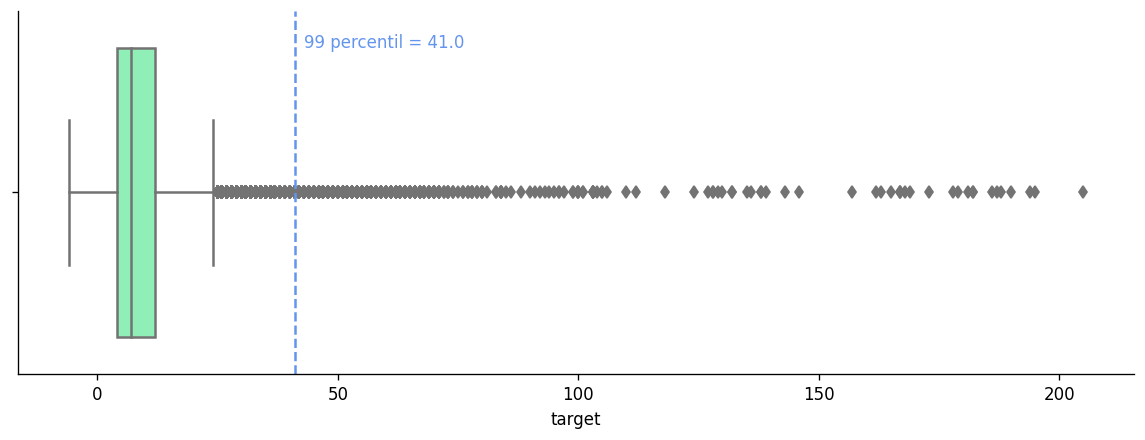

In [23]:
fig = plt.figure(figsize=(12, 4), dpi=120)
ax = fig.add_subplot(111)
sns.boxplot(x="target", data=orders_df, palette="rainbow", ax=ax)
p99 = orders_df["target"].quantile(0.99)
plt.axvline(x=p99, linestyle='--', color='cornflowerblue')
plt.text(p99 + 2, -0.4, f'99 percentil = {p99}', color='cornflowerblue')
sns.despine()

### O que seria um target estranho?

* valor negativo: entregou antes de postar

* zero: embora não seja impossível, não parece plausível

In [24]:
len(orders_df[orders_df["target"] <= 0])

264

* vamos remover esses valores do dataset

In [25]:
orders_df = orders_df[orders_df["target"] > 0]

## Preparação dos dados

In [26]:
full_dataset = orders_df.sort_values(by="order_delivered_customer_date").reset_index(drop=True)

### Divisão do dataset em treino e teste
Usando [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) da biblioteca sklearn, fazemos a divisão de forma que deixamos 20% para nossa base de teste.

In [27]:
datasets = {}

In [28]:
datasets["train"], datasets["test"] = train_test_split(full_dataset, test_size=.2, random_state=0, shuffle=False)

### Processamento de features

Features categóricas: média do prazo de entrega (`target`) no dataset de treino
* `from_to`
* `customer_city`

Features binárias: sem tratamento
* `same_city`
* `same_state`

Features numéricas: normalização de valores usando o [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
* `zip_code_prefix_match`
* `customer_lat`
* `customer_long`
* `seller_lat`
* `seller_long`
* `geo_distance`

In [29]:
features = {
    "categorical": ["from_to", "customer_city"],
    "binary": ["same_city", "same_state"],
    "numerical": ["zip_code_prefix_match", "customer_lat",
                 "customer_long", "seller_lat", "seller_long", "geo_distance"]
}

In [30]:
def process_numerical_feature(df, colname, scaler):
    df[f"{colname}_scaled"] = scaler.transform(df[[colname]]).reshape(-1)
    return df.drop(colname, 1)

def scale_numerical_cols(df, cols, scalers):
    for colname in cols:
        df = process_numerical_feature(df, colname, scalers[colname])
    return df

In [31]:
def create_avg_categorical_cols(df, cols, all_categories):
    for colname in cols:
        from_to_values, mean_val = all_categories[colname]
        df[f"{colname}_avg"] = df[colname].apply(lambda val: from_to_values.get(val, mean_val))
    return df

In [32]:
for dataset_type in ["train", "test"]:
    df = datasets[dataset_type]
    if dataset_type == "train":
        all_categories = {
            col: (df.groupby(col).agg({"target": "mean"})["target"].to_dict(), df["target"].mean()) for col in features["categorical"]
        }
        scalers = {
            col: MinMaxScaler().fit(df[[col]]) for col in features["numerical"]
        }
    df = create_avg_categorical_cols(df, features["categorical"], all_categories)
    datasets[dataset_type] = scale_numerical_cols(df, features["numerical"], scalers)

#### Informações do dataset de treino

In [33]:
feature_cols = features["binary"] + [f"{col}_avg" for col in features["categorical"]] + [f"{col}_scaled" for col in features["numerical"]]

In [34]:
datasets["train"][feature_cols].describe()

,same_city,same_state,from_to_avg,customer_city_avg,zip_code_prefix_match_scaled,customer_lat_scaled,customer_long_scaled,seller_lat_scaled,seller_long_scaled,geo_distance_scaled
count,69256.000000,69256.000000,69256.000000,69256.000000,69256.000000,69256.000000,69256.000000,69256.000000,69256.000000,69256.000000
mean,0.048097,0.349876,10.127671,10.127671,0.048848,0.165875,0.366119,0.290436,0.262393,0.077319
std,0.213973,0.476934,4.606773,4.779283,0.104258,0.076076,0.065564,0.087855,0.051199,0.084649
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.241891,5.633508,0.000000,0.133185,0.336611,0.264234,0.237592,0.025181
50%,0.000000,0.000000,9.796694,9.123288,0.000000,0.142044,0.358323,0.270370,0.268340,0.054122
75%,0.000000,1.000000,13.890380,12.633880,0.000000,0.180270,0.400490,0.322188,0.271921,0.098964
max,1.000000,1.000000,138.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
datasets["train"][feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69256 entries, 0 to 69255
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   same_city                     69256 non-null  int64  
 1   same_state                    69256 non-null  int64  
 2   from_to_avg                   69256 non-null  float64
 3   customer_city_avg             69256 non-null  float64
 4   zip_code_prefix_match_scaled  69256 non-null  float64
 5   customer_lat_scaled           69256 non-null  float64
 6   customer_long_scaled          69256 non-null  float64
 7   seller_lat_scaled             69256 non-null  float64
 8   seller_long_scaled            69256 non-null  float64
 9   geo_distance_scaled           69256 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 5.8 MB


## Construção do modelo

Usamos aqui como exemplo um modelo linear

In [36]:
model = LinearRegression()
model = model.fit(datasets["train"][feature_cols], datasets["train"]["target"])

### Métricas para avaliação

Para regressão, é comum utilizarmos uma das seguintes métricas para avaliar nosso modelo:

* `MAE` ([Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)): é a média do valor absoluto da diferença entre o valor predito e o valor real.

$$MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y_i}| $$


* `RMSE` (Root Mean Squared Error): é a raiz quadrada da média do quadrado da diferença entre o valor predito e o valor real - por elevar ao quadrado o erro, penaliza erros maiores.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(y_i - \hat{y_i}\right)^2} $$

**Nota:** a biblioteca `scikit-learn` tem implementado o `MSE` ([Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)). A cálculo do `MSE` segue: $MSE = \frac{1}{n} \sum_{i=1}^n \left(y_i - \hat{y_i}\right)^2$. Para calcular o `RMSE`, basta tirar a raiz quadrada desse valor.

* `r2` ([R2 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)): é uma medida que indica o quanto o modelo é melhor em relação a um modelo que faz a predição com base no valor médio do target. Seu valor é entre menos infinito ($-\infty$) e 1.

$$R^2 = 1 - \frac{MSE}{Var(y)} = 1 - \frac{\frac{1}{n} \sum_{i=1}^n \left(y_i - \hat{y_i}\right)^2}{\frac{1}{n} \sum_{i=1}^n \left(y_i - \bar{y}\right)^2}$$

As fórmulas acima consideram:

* $n$: o número de exemplos avaliados;
* $y_i$: o valor real de `target` para o exemplo $i$;
* $\hat{y_i}$: o valor predito para o `target` para o exemplo $i$;
* $\bar{y}$: o valor médio dos valores reais de `target`.

In [37]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

* cálculo do MAE e RMSE para nosso modelo no dataset de teste

In [38]:
y_true = datasets["test"]["target"].values
y_pred = model.predict(datasets["test"][feature_cols])

In [39]:
mean_absolute_error(y_true, y_pred)

4.7902947946411265

In [40]:
rmse(y_true, y_pred)

7.285855504977357

#### Quão bom é esse resultado?

* cálculo do $R^2$

* cálculo do RMSE para usando como valor predito o valor médio

In [41]:
r2_score(y_true, y_pred)

-0.04666114709843394

In [42]:
train_dataset_target_mean = datasets["train"]["target"].mean()
mean_pred = [train_dataset_target_mean] * len(y_true)

In [43]:
mean_absolute_error(y_true, mean_pred)

5.784155552660638

In [44]:
rmse(y_true, mean_pred)

7.949491658540457

In [45]:
def create_metrics_comparison_table(model, model_name, test_df, target_mean):
    metrics_results = {"model": [], "mae": [], "rmse": [], "r2": []}
    y_true = test_df["target"].values
    predictions = {
        model_name: model.predict(test_df[feature_cols]),
        "naive": [target_mean] * len(y_true)}
    for name, y_pred in predictions.items():
        metrics_results["model"].append(name)
        metrics_results["mae"].append(mean_absolute_error(y_true, y_pred))
        metrics_results["rmse"].append(rmse(y_true, y_pred))
        metrics_results["r2"].append(r2_score(y_true, y_pred))
    
    return pd.DataFrame(metrics_results)    

In [46]:
create_metrics_comparison_table(model, "linear_regression", datasets["test"], train_dataset_target_mean)

,model,mae,rmse,r2
0,linear_regression,4.790295,7.285856,-0.046661
1,naive,5.784156,7.949492,-0.246016


### Resultados por estado de origem e destino

In [47]:
frequent_from_to = datasets["test"]["from_to"].value_counts().head(n=5).index.tolist()

In [48]:
for from_to_states in frequent_from_to:
    print(from_to_states)
    aux_df = datasets["test"][datasets["test"]["from_to"] == from_to_states]
    display(create_metrics_comparison_table(model, "linear_regression", aux_df))

SP->SP


,model,mae,rmse,r2
0,linear_regression,2.579363,4.377638,-0.097796
1,naive,7.171914,7.939061,-2.610608


RJ->SP


,model,mae,rmse,r2
0,linear_regression,8.085302,10.845362,-0.351492
1,naive,5.486151,9.508396,-0.038819


MG->SP


,model,mae,rmse,r2
0,linear_regression,4.731349,5.603713,-0.890816
1,naive,5.141038,5.779130,-1.011048


RS->SP


,model,mae,rmse,r2
0,linear_regression,6.803273,8.192926,-0.916516
1,naive,3.677970,6.027035,-0.037150


PR->SP


,model,mae,rmse,r2
0,linear_regression,4.638017,5.286761,-0.748481
1,naive,4.687030,5.305960,-0.761203


### Comparação com a estimativa original do dataset

In [49]:
def calc_diff_dates_estimate(row):
    carrier_date = row["order_delivered_carrier_date_timestamp"]
    estimated_date = row["order_estimated_delivery_date_timestamp"]
    return (estimated_date - carrier_date).days

In [50]:
datasets["test"]["order_estimated_delivery_date_timestamp"] = pd.to_datetime(pd.to_datetime(datasets["test"]["order_estimated_delivery_date"]).dt.strftime("%Y-%m-%d"))
datasets["test"]["original_estimate"] = datasets["test"].apply(calc_diff_dates_estimate, 1)

In [51]:
original_estimate = datasets["test"]["original_estimate"].values

In [52]:
metrics_results = {
    "model": ["linear_regression", "naive", "original"],
    "mae": [mean_absolute_error(y_true, y_pred), mean_absolute_error(y_true, mean_pred), mean_absolute_error(y_true, original_estimate)],
    "rmse": [rmse(y_true, y_pred), rmse(y_true, mean_pred), rmse(y_true, original_estimate)],
    "r2": [r2_score(y_true, y_pred), 0, r2_score(y_true, original_estimate)]
}

pd.DataFrame(metrics_results)

,model,mae,rmse,r2
0,linear_regression,4.790295,7.285856,-0.046661
1,naive,5.784156,7.949492,0.000000
2,original,13.347696,16.237861,-4.198794
